<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S7_ASSIGNMENT/CODE4_ALLDILATIONS_84P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [3]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [4]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(),
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [5]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [6]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [8]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [9]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
#chsum = 0
##pbar = tqdm(train_loader_nonorm)

#for index, (data,target) in enumerate(train_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(train_nonorm) * 32 *32)
#
#chsum = None
#for index, (data,target) in enumerate(train_loader_nonorm):
#  if index == 0:
#   print(data.min(),data.max())
#   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
#print("Traindata Mean",mean)
#print("Traindata std dev",std)

#chsum = 0

#for index, (data,target) in enumerate(test_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(test_nonorm) * 32 *32)

#chsum = None
#for index, (data,target) in enumerate(test_loader_nonorm):
#  if index == 0:
#    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
#print("Test data Mean",mean)
#print("Test data std dev",std)

ship


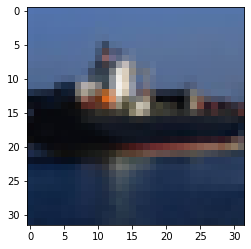

In [11]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [19]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 
        
       #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation =1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling / stride =2 conv
        self.pool1_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32 , kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64 ,kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            #nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            #nn.BatchNorm2d(256),
            #nn.ReLU(),
            #nn.Dropout(dropout_perc),
            #nn.Conv2d(in_channels=256, out_channels=512, groups = 256 ,kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            #nn.BatchNorm2d(512),
            #nn.ReLU(),
            #nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        )
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=0, dilation = 2 ,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=0, dilation =2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        self.pool2_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32, kernel_size=(3, 3), padding=0, dilation =2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=0, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0,bias=False)
        )

        #BLOCK C3

        self.convblock8a = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32, kernel_size=(3, 3), padding=2, dilation =2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=2, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=2, dilation=2 , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        self.pool3_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups=32 , kernel_size=(3, 3), padding=0, dilation = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #BLOCK C4
        
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=2, dilation=2 , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), padding=2, dilation =2,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=256, groups = 256, out_channels=512, kernel_size=(3, 3), padding=2, dilation=2, bias=False)
        ) 

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(512,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock4(x)
        
        #x = self.pool1(x)
        x = self.pool1_dilation(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        #x = self.pool2(x)
        x = self.pool2_dilation(x)

        x = self.convblock8a(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        #x = self.pool3(x)
        x = self.pool3_dilation(x)
        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [20]:
model = BatchNormNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 28, 28]             576
      BatchNorm2d-11           [-1, 64, 28, 28]             128
             ReLU-12           [-1, 64, 28, 28]               0
          Dropout-13           [-1, 64, 28, 28]               0
           Conv2d-14          [-1, 128,

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [14]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [15]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.7)

  for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    
    scheduler.step()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))

  test_10_images_unnorm = []
  for img in test_10_images:
    img = img.cpu()
    img = img.numpy()
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.2435 + 0.4822
    img[2] = img[2] * 0.2616 + 0.4465

    img = torch.from_numpy(img)
    test_10_images_unnorm.append(img)
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

  return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 28, 28]             576
      BatchNorm2d-11           [-1, 64, 28, 28]             128
             ReLU-12           [-1, 64, 28, 28]               0
          Dropout-13           [-1, 64, 28, 28]               0
           Conv2d-14          [-1, 128,

Loss=2.479185104370117 Batch_id=390 Accuracy=28.98: 100%|██████████| 391/391 [00:24<00:00, 15.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 15106.4855, Accuracy: 4470/10000 (44.70%)

Epoch 1, lr 0.02


Loss=2.213766574859619 Batch_id=390 Accuracy=45.69: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 12144.0125, Accuracy: 5588/10000 (55.88%)

Epoch 2, lr 0.02


Loss=1.973321795463562 Batch_id=390 Accuracy=51.00: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 11041.5604, Accuracy: 6009/10000 (60.09%)

Epoch 3, lr 0.02


Loss=1.9581996202468872 Batch_id=390 Accuracy=54.41: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 10450.6673, Accuracy: 6333/10000 (63.33%)

Epoch 4, lr 0.02


Loss=2.019066333770752 Batch_id=390 Accuracy=57.06: 100%|██████████| 391/391 [00:24<00:00, 15.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9664.1041, Accuracy: 6595/10000 (65.95%)

Epoch 5, lr 0.02


Loss=1.7035644054412842 Batch_id=390 Accuracy=58.80: 100%|██████████| 391/391 [00:24<00:00, 15.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9745.3579, Accuracy: 6600/10000 (66.00%)

Epoch 6, lr 0.02


Loss=1.8542261123657227 Batch_id=390 Accuracy=60.24: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9371.6111, Accuracy: 6705/10000 (67.05%)

Epoch 7, lr 0.02


Loss=1.502761721611023 Batch_id=390 Accuracy=61.66: 100%|██████████| 391/391 [00:24<00:00, 15.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8980.7966, Accuracy: 6876/10000 (68.76%)

Epoch 8, lr 0.013999999999999999


Loss=1.6015584468841553 Batch_id=390 Accuracy=63.26: 100%|██████████| 391/391 [00:24<00:00, 15.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8163.6126, Accuracy: 7184/10000 (71.84%)

Epoch 9, lr 0.013999999999999999


Loss=1.5652449131011963 Batch_id=390 Accuracy=64.22: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7816.3616, Accuracy: 7249/10000 (72.49%)

Epoch 10, lr 0.013999999999999999


Loss=1.4263898134231567 Batch_id=390 Accuracy=64.75: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7563.2086, Accuracy: 7389/10000 (73.89%)

Epoch 11, lr 0.013999999999999999


Loss=1.525159239768982 Batch_id=390 Accuracy=65.41: 100%|██████████| 391/391 [00:24<00:00, 15.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7755.1213, Accuracy: 7260/10000 (72.60%)

Epoch 12, lr 0.013999999999999999


Loss=1.6972429752349854 Batch_id=390 Accuracy=65.79: 100%|██████████| 391/391 [00:24<00:00, 15.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8168.2232, Accuracy: 7183/10000 (71.83%)

Epoch 13, lr 0.013999999999999999


Loss=1.5920801162719727 Batch_id=390 Accuracy=65.91: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7391.9926, Accuracy: 7453/10000 (74.53%)

Epoch 14, lr 0.013999999999999999


Loss=1.5050808191299438 Batch_id=390 Accuracy=66.41: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6972.7695, Accuracy: 7586/10000 (75.86%)

Epoch 15, lr 0.013999999999999999


Loss=1.488016963005066 Batch_id=390 Accuracy=66.74: 100%|██████████| 391/391 [00:24<00:00, 15.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7182.7488, Accuracy: 7477/10000 (74.77%)

Epoch 16, lr 0.013999999999999999


Loss=1.3008177280426025 Batch_id=390 Accuracy=67.04: 100%|██████████| 391/391 [00:24<00:00, 15.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7368.6564, Accuracy: 7465/10000 (74.65%)

Epoch 17, lr 0.009799999999999998


Loss=1.4173521995544434 Batch_id=390 Accuracy=68.34: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6572.3859, Accuracy: 7675/10000 (76.75%)

Epoch 18, lr 0.009799999999999998


Loss=1.7532631158828735 Batch_id=390 Accuracy=68.58: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6490.3920, Accuracy: 7761/10000 (77.61%)

Epoch 19, lr 0.009799999999999998


Loss=1.4865643978118896 Batch_id=390 Accuracy=68.90: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6710.1932, Accuracy: 7669/10000 (76.69%)

Epoch 20, lr 0.009799999999999998


Loss=1.4607009887695312 Batch_id=390 Accuracy=68.91: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6754.4643, Accuracy: 7650/10000 (76.50%)

Epoch 21, lr 0.009799999999999998


Loss=1.5685176849365234 Batch_id=390 Accuracy=68.76: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6324.0029, Accuracy: 7854/10000 (78.54%)

Epoch 22, lr 0.009799999999999998


Loss=1.3925228118896484 Batch_id=390 Accuracy=69.44: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7074.7382, Accuracy: 7563/10000 (75.63%)

Epoch 23, lr 0.009799999999999998


Loss=1.5392916202545166 Batch_id=390 Accuracy=69.25: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6595.6988, Accuracy: 7725/10000 (77.25%)

Epoch 24, lr 0.009799999999999998


Loss=1.4703813791275024 Batch_id=390 Accuracy=69.48: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6378.8500, Accuracy: 7785/10000 (77.85%)

Epoch 25, lr 0.009799999999999998


Loss=1.617244005203247 Batch_id=390 Accuracy=69.52: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6408.4696, Accuracy: 7794/10000 (77.94%)

Epoch 26, lr 0.006859999999999998


Loss=1.2170906066894531 Batch_id=390 Accuracy=70.61: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6159.9223, Accuracy: 7878/10000 (78.78%)

Epoch 27, lr 0.006859999999999998


Loss=1.430304765701294 Batch_id=390 Accuracy=71.16: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5731.1258, Accuracy: 8017/10000 (80.17%)

Epoch 28, lr 0.006859999999999998


Loss=1.2941851615905762 Batch_id=390 Accuracy=71.17: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5916.1777, Accuracy: 7966/10000 (79.66%)

Epoch 29, lr 0.006859999999999998


Loss=1.0562729835510254 Batch_id=390 Accuracy=71.11: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6146.7461, Accuracy: 7908/10000 (79.08%)

Epoch 30, lr 0.006859999999999998


Loss=1.26677405834198 Batch_id=390 Accuracy=71.26: 100%|██████████| 391/391 [00:24<00:00, 15.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6104.2202, Accuracy: 7927/10000 (79.27%)

Epoch 31, lr 0.006859999999999998


Loss=1.2016031742095947 Batch_id=390 Accuracy=71.45: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6165.1463, Accuracy: 7910/10000 (79.10%)

Epoch 32, lr 0.006859999999999998


Loss=1.2186384201049805 Batch_id=390 Accuracy=71.49: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6026.0043, Accuracy: 7914/10000 (79.14%)

Epoch 33, lr 0.006859999999999998


Loss=1.1835334300994873 Batch_id=390 Accuracy=71.36: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5928.6601, Accuracy: 8016/10000 (80.16%)

Epoch 34, lr 0.006859999999999998


Loss=1.1236824989318848 Batch_id=390 Accuracy=71.69: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5827.3868, Accuracy: 8009/10000 (80.09%)

Epoch 35, lr 0.004801999999999998


Loss=1.4242044687271118 Batch_id=390 Accuracy=72.34: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5605.9417, Accuracy: 8109/10000 (81.09%)

Epoch 36, lr 0.004801999999999998


Loss=1.2619661092758179 Batch_id=390 Accuracy=72.28: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5403.6539, Accuracy: 8142/10000 (81.42%)

Epoch 37, lr 0.004801999999999998


Loss=1.5055122375488281 Batch_id=390 Accuracy=72.84: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5643.5852, Accuracy: 8100/10000 (81.00%)

Epoch 38, lr 0.004801999999999998


Loss=1.0830577611923218 Batch_id=390 Accuracy=72.84: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5509.0586, Accuracy: 8098/10000 (80.98%)

Epoch 39, lr 0.004801999999999998


Loss=1.199777364730835 Batch_id=390 Accuracy=72.81: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5643.6778, Accuracy: 8073/10000 (80.73%)

Epoch 40, lr 0.004801999999999998


Loss=1.1707580089569092 Batch_id=390 Accuracy=72.69: 100%|██████████| 391/391 [00:24<00:00, 15.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5413.6644, Accuracy: 8162/10000 (81.62%)

Epoch 41, lr 0.004801999999999998


Loss=1.101693868637085 Batch_id=390 Accuracy=72.87: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5685.9156, Accuracy: 8064/10000 (80.64%)

Epoch 42, lr 0.004801999999999998


Loss=1.1446728706359863 Batch_id=390 Accuracy=72.57: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5880.7022, Accuracy: 8017/10000 (80.17%)

Epoch 43, lr 0.004801999999999998


Loss=1.282638430595398 Batch_id=390 Accuracy=72.86: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5727.4225, Accuracy: 8048/10000 (80.48%)

Epoch 44, lr 0.0033613999999999983


Loss=1.1388250589370728 Batch_id=390 Accuracy=73.82: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5326.1743, Accuracy: 8173/10000 (81.73%)

Epoch 45, lr 0.0033613999999999983


Loss=1.4171439409255981 Batch_id=390 Accuracy=73.87: 100%|██████████| 391/391 [00:24<00:00, 15.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5340.0138, Accuracy: 8190/10000 (81.90%)

Epoch 46, lr 0.0033613999999999983


Loss=1.226731538772583 Batch_id=390 Accuracy=73.86: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5305.6484, Accuracy: 8209/10000 (82.09%)

Epoch 47, lr 0.0033613999999999983


Loss=1.1841151714324951 Batch_id=390 Accuracy=73.67: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5342.0301, Accuracy: 8214/10000 (82.14%)

Epoch 48, lr 0.0033613999999999983


Loss=1.1546558141708374 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5482.6958, Accuracy: 8121/10000 (81.21%)

Epoch 49, lr 0.0033613999999999983


Loss=1.2412234544754028 Batch_id=390 Accuracy=74.08: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5492.0095, Accuracy: 8119/10000 (81.19%)

Epoch 50, lr 0.0033613999999999983


Loss=1.387756586074829 Batch_id=390 Accuracy=74.05: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5218.6476, Accuracy: 8181/10000 (81.81%)

Epoch 51, lr 0.0033613999999999983


Loss=1.2050731182098389 Batch_id=390 Accuracy=74.09: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5332.8237, Accuracy: 8197/10000 (81.97%)

Epoch 52, lr 0.0033613999999999983


Loss=1.2213513851165771 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5310.8560, Accuracy: 8169/10000 (81.69%)

Epoch 53, lr 0.002352979999999999


Loss=1.3451793193817139 Batch_id=390 Accuracy=74.59: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5097.2360, Accuracy: 8287/10000 (82.87%)

Epoch 54, lr 0.002352979999999999


Loss=1.0649797916412354 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5233.3533, Accuracy: 8224/10000 (82.24%)

Epoch 55, lr 0.002352979999999999


Loss=1.3398481607437134 Batch_id=390 Accuracy=74.93: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5198.0193, Accuracy: 8258/10000 (82.58%)

Epoch 56, lr 0.002352979999999999


Loss=1.1569902896881104 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5183.5008, Accuracy: 8231/10000 (82.31%)

Epoch 57, lr 0.002352979999999999


Loss=1.377482533454895 Batch_id=390 Accuracy=75.06: 100%|██████████| 391/391 [00:24<00:00, 15.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5258.7733, Accuracy: 8213/10000 (82.13%)

Epoch 58, lr 0.002352979999999999


Loss=0.9166117310523987 Batch_id=390 Accuracy=75.07: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5287.2637, Accuracy: 8216/10000 (82.16%)

Epoch 59, lr 0.002352979999999999


Loss=1.3396501541137695 Batch_id=390 Accuracy=74.79: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5091.4154, Accuracy: 8290/10000 (82.90%)

Epoch 60, lr 0.002352979999999999


Loss=1.095950961112976 Batch_id=390 Accuracy=75.05: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4968.7845, Accuracy: 8313/10000 (83.13%)

Epoch 61, lr 0.002352979999999999


Loss=1.3577096462249756 Batch_id=390 Accuracy=74.93: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5096.3843, Accuracy: 8277/10000 (82.77%)

Epoch 62, lr 0.0016470859999999992


Loss=1.1238212585449219 Batch_id=390 Accuracy=75.53: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4942.5839, Accuracy: 8318/10000 (83.18%)

Epoch 63, lr 0.0016470859999999992


Loss=1.1767494678497314 Batch_id=390 Accuracy=75.62: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4907.1640, Accuracy: 8365/10000 (83.65%)

Epoch 64, lr 0.0016470859999999992


Loss=1.2407692670822144 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4990.8560, Accuracy: 8324/10000 (83.24%)

Epoch 65, lr 0.0016470859999999992


Loss=1.0734702348709106 Batch_id=390 Accuracy=75.86: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4955.4987, Accuracy: 8335/10000 (83.35%)

Epoch 66, lr 0.0016470859999999992


Loss=1.092394471168518 Batch_id=390 Accuracy=75.94: 100%|██████████| 391/391 [00:24<00:00, 15.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4957.4321, Accuracy: 8331/10000 (83.31%)

Epoch 67, lr 0.0016470859999999992


Loss=1.02629554271698 Batch_id=390 Accuracy=75.67: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5003.1581, Accuracy: 8322/10000 (83.22%)

Epoch 68, lr 0.0016470859999999992


Loss=1.1807700395584106 Batch_id=390 Accuracy=75.81: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4821.9677, Accuracy: 8383/10000 (83.83%)

Epoch 69, lr 0.0016470859999999992


Loss=1.118133544921875 Batch_id=390 Accuracy=75.75: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5019.0236, Accuracy: 8307/10000 (83.07%)

Epoch 70, lr 0.0016470859999999992


Loss=1.0204919576644897 Batch_id=390 Accuracy=75.85: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4899.1853, Accuracy: 8370/10000 (83.70%)

Epoch 71, lr 0.0011529601999999994


Loss=1.1582269668579102 Batch_id=390 Accuracy=76.03: 100%|██████████| 391/391 [00:24<00:00, 15.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5005.1508, Accuracy: 8331/10000 (83.31%)

Epoch 72, lr 0.0011529601999999994


Loss=0.9414776563644409 Batch_id=390 Accuracy=76.39: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4892.8425, Accuracy: 8370/10000 (83.70%)

Epoch 73, lr 0.0011529601999999994


Loss=1.037196397781372 Batch_id=390 Accuracy=76.39: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4804.7725, Accuracy: 8383/10000 (83.83%)

Epoch 74, lr 0.0011529601999999994


Loss=0.9228255152702332 Batch_id=390 Accuracy=76.34: 100%|██████████| 391/391 [00:24<00:00, 15.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4862.8842, Accuracy: 8354/10000 (83.54%)

Epoch 75, lr 0.0011529601999999994


Loss=1.0655251741409302 Batch_id=390 Accuracy=76.19: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4948.2284, Accuracy: 8343/10000 (83.43%)

Epoch 76, lr 0.0011529601999999994


Loss=1.1310920715332031 Batch_id=390 Accuracy=76.21: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4714.0528, Accuracy: 8402/10000 (84.02%)

Epoch 77, lr 0.0011529601999999994


Loss=1.1856367588043213 Batch_id=390 Accuracy=76.40: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4780.2863, Accuracy: 8350/10000 (83.50%)

Epoch 78, lr 0.0011529601999999994


Loss=1.3995531797409058 Batch_id=390 Accuracy=76.21: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4890.5001, Accuracy: 8354/10000 (83.54%)

Epoch 79, lr 0.0011529601999999994


Loss=1.201013445854187 Batch_id=390 Accuracy=76.45: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4886.6224, Accuracy: 8340/10000 (83.40%)

Epoch 80, lr 0.0008070721399999995


Loss=0.937731921672821 Batch_id=390 Accuracy=77.12: 100%|██████████| 391/391 [00:24<00:00, 15.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4796.9755, Accuracy: 8393/10000 (83.93%)

Epoch 81, lr 0.0008070721399999995


Loss=1.125795602798462 Batch_id=390 Accuracy=76.89: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4720.0774, Accuracy: 8404/10000 (84.04%)

Epoch 82, lr 0.0008070721399999995


Loss=0.891079306602478 Batch_id=390 Accuracy=76.67: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4711.0833, Accuracy: 8407/10000 (84.07%)

Epoch 83, lr 0.0008070721399999995


Loss=1.227959156036377 Batch_id=390 Accuracy=76.76: 100%|██████████| 391/391 [00:24<00:00, 15.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4772.2221, Accuracy: 8403/10000 (84.03%)

Epoch 84, lr 0.0008070721399999995


Loss=1.1520891189575195 Batch_id=390 Accuracy=76.89: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s]



Test set: Average loss: 4725.0722, Accuracy: 8398/10000 (83.98%)

Actual Labels
horse   cat truck  deer  bird   dog   dog   cat   dog   dog
Predicted Labels
 deer   dog   car  bird plane plane  deer horse horse horse


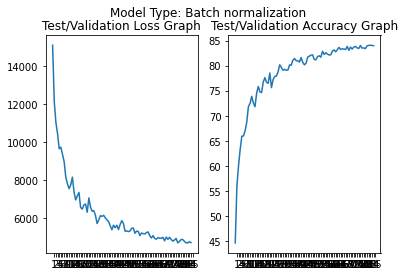

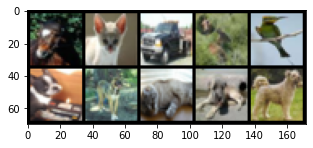

In [16]:
test_10_images, test_10_images_target , test_10_pred_target = main(0,100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


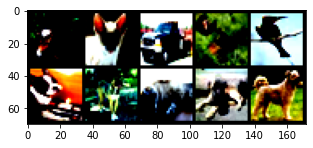

In [17]:
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

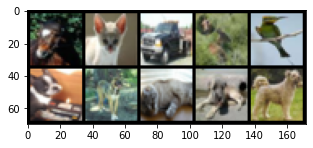

In [18]:
test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
  
